In [1]:
# 第一次在 Google Colab/Jupyter Notebook 執行請安裝 AutoKeras

!pip3 install autokeras

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://www.piwheels.org/simple


In [2]:
# 若第一次在本機使用 Jupyter Notebook, 移除下一行的 # 號並執行之
# (Windows 使用者也得先安裝 https://graphviz.org/download/#windows)

#!pip3 install pydot pydot-ng pydotplus graphviz

# 安裝完成後重啟 Python kernel (Kernel -> Restart)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import autokeras as ak

In [4]:
from sklearn.datasets import fetch_20newsgroups

train = fetch_20newsgroups(subset='train')
train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [5]:
categories = ['comp.sys.ibm.pc.hardware',
              'rec.autos',
              'rec.sport.baseball', 
              'sci.med',
              'sci.space',
              'talk.politics.mideast']

train = fetch_20newsgroups(subset='train', 
                           categories=categories,
                           remove=('headers', 'footers', 'quotes'))
test = fetch_20newsgroups(subset='test',
                          categories=categories,
                          remove=('headers', 'footers', 'quotes'))

x_train = np.array(train.data)
y_train = np.array(train.target)
x_test = np.array(test.data)
y_test = np.array(test.target)

print(x_train.shape)
print(x_test.shape)

(3532,)
(2351,)


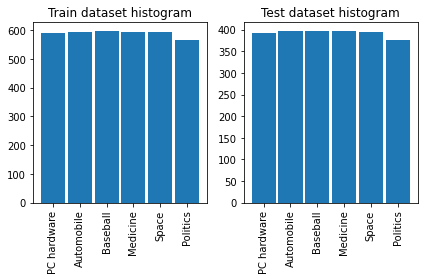

In [6]:
fig = plt.figure()
bin = np.arange(len(categories) + 1)

labels = ('PC hardware', 'Automobile', 'Baseball', 
          'Medicine', 'Space', 'Politics', '')

ax = fig.add_subplot(1, 2, 1)
ax.set_xticks(bin)
ax.set_xticklabels(labels, rotation=90)
plt.hist(y_train, bins=bin-0.5, rwidth=0.9)
ax.set_title('Train dataset histogram')

ax = fig.add_subplot(1, 2, 2)
ax.set_xticks(bin)
ax.set_xticklabels(labels, rotation=90)
plt.hist(y_test, bins=bin-0.5, rwidth=0.9)
ax.set_title('Test dataset histogram')

plt.tight_layout()
plt.show()

In [7]:
from keras_tuner.engine.hyperparameters import Choice

pretraining = Choice(name='pretraining', values=['word2vec'])
num_blocks = Choice(name='num_blocks', values=[1])

cbs = [tf.keras.callbacks.EarlyStopping(patience=3)]

input_node = ak.TextInput()

output_node = ak.TextToIntSequence(max_tokens=50000)(input_node)
output_node = ak.Embedding(
    pretraining=pretraining, max_features=50000)(output_node)
output_node = ak.ConvBlock( 
    num_blocks=num_blocks, separable=True, max_pooling=True)(output_node)
output_node = ak.SpatialReduction(reduction_type='global_max')(output_node)
output_node = ak.ClassificationHead()(output_node)

clf = ak.AutoModel(inputs=input_node, outputs=output_node, 
                   max_trials=20, overwrite=True)
clf.fit(x_train, y_train, callbacks=cbs)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
64                |?                 |text_to_int_sequence_1/output_sequence_length
word2vec          |?                 |embedding_1/pretraining
128               |?                 |embedding_1/embedding_dim
0.25              |?                 |embedding_1/dropout
3                 |?                 |conv_block_1/kernel_size
1                 |?                 |conv_block_1/num_blocks
2                 |?                 |conv_block_1/num_layers
32                |?                 |conv_block_1/filters_0_0
32                |?                 |conv_block_1/filters_0_1
0                 |?                 |conv_block_1/dropout
0                 |?                 |classification_head_1/dropout
adam              |?                 |optimizer
0.001             |?                 |learning_rate

Epoch 1/1000
89/89 [==============================] - 36s 374ms/step - loss: 1.7917 - accuracy: 0.1678 - val_lo

: 

: 

In [ ]:
clf.evaluate(x_test, y_test)

In [ ]:
predicted = clf.predict(x_test).flatten().astype('uint8')

for i in range(10):
    print('TEXT [')
    print(x_test[i].strip()[:400])
    print(f'] PREDICTED: {labels[predicted[i]]}, REAL: {labels[y_test[i]]}')
    print('')

In [ ]:
labels = ('PC hardware', 'Automobile', 'Baseball', 
          'Medicine', 'Space', 'Politics')

from sklearn.metrics import classification_report
print(classification_report(y_test, predicted, target_names=labels))

In [ ]:
model = clf.export_model()
model.summary()

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)